# Capstone Project

## Multi-factor Model with Machine Learning

## 1. Package Preparation

In [358]:
import pandas as pd
import numpy as np
import datetime
import quandl
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import train_test_split
import os
import seaborn as sns

## 2. Data Extraction and Exploration

In [70]:
# Before starting, we need to register for a quandl api key at https://www.quandl.com/
quandl.ApiConfig.api_key = 'Ufux_HxUXZKAgFjxWhGi'

Here we use all the 30 stocks that Dow Joes Index measures, of course we can choose other stock pools.

In [45]:
# 30 stocks ticker of Dow Jones index
stock_list = ['DOW','UNH','JPM','CAT','BA','XOM','WBA','GS','MMM','UTX','WMT','DIS',
              'JNJ','CSCO','AXP','HD','CVX','IBM','MSFT','MRK','NKE','V','PG','VZ','KO',
              'INTC','PFE','MCD','TRV','AAPL']

### 2.1 Calculate Fundamental Features

There are all kinds of fundamental features and we select 5 including RoA, P/B, P/E, P/S, current ratio. <br />

**RoA**: Return on Assets (ROA) is an indicator of how well a company utilizes its assets, by determining how profitable a company is relative to its total assets. <br />

<center>$RoA=\frac{Net~Income}{Total~Assets}$ <br />

**P/B**: The Price-To-Book (P/B) ratio measures the market's valuation of a company relative to its book value.

<center> $P/B~Ratio=\frac{Market~Price~per~Share}{Book~Price~per~Share}$ <br />
    
**P/E**: The price-to-earnings ratio (P/E ratio) is the ratio for valuing a company that measures its current share price relative to its per-share earnings (EPS). A high P/E ratio could mean that a company's stock is over-valued, or else that investors are expecting high 
growth rates in the future.

<center> $P/E~Ratio=\frac{Market~Price~per~Share}{Earnings~per~Share}$
    
**P/S**: The price-to-sales (P/S) ratio is a valuation ratio that compares a company’s stock price to its revenues. It is an indicator of the value placed on each dollar of a company’s sales or revenues. It is a key analysis and valuation tool that shows how much investors are willing to pay per dollar of sales for a stock. 

<center> $P/S~Ratio=\frac{Market~Value~per~Share}{Sales~per~Share}$<br />
    
**Current Ratio**: The current ratio is a liquidity ratio that measures a company's ability to pay short-term obligations or those due within one year. The current ratio is sometimes referred to as the “working capital” ratio and helps investors understand more about a company’s ability to cover its short-term debt with its current assets.

<center> $Current~Ratio=\frac{Current~Assets}{Current~Liabilities}$

In [74]:
# function for calculating fundamental features
def calculate_fundamental_features(ticker):
    df = quandl.get_table('SHARADAR/SF1', ticker = ticker)[['datekey', 'roa','pb', 'pe','ps','currentratio']]
    # The fundamental data is not updated daily, so the latest data may not be 2018.5.1, 
    # so we need to retreive earlier data
    df = df[df['datekey'] > pd.Timestamp(2017,1,1)]
    df = df.drop_duplicates(subset=['datekey'], keep='first')
    df.index=df['datekey']
    df = df.drop(['datekey'],axis=1)
    return df

### 2.2 Calculate Technical Features

We select the following technical features: MACD, RSI, KDJ, OBV, VR and Momentum.

#### a. MACD

Moving Average Convergence Divergence (MACD) is a trend-following momentum indicator that shows the relationship between two moving averages of a security's price. The MACD is calculated by subtracting the 26-period Exponential Moving Average (EMA) from the 12-period EMA.

<center>$MACD=2\times(DIF-DEA)$<br />
$DIF=EMA(12)-EMA(26)$ <br />
$DEA=EMA(DIF)$

A fast EMA responds more quickly than a slow EMA to recent changes in a stock's price. By comparing EMAs of different periods, the MACD series can indicate changes in the trend of a stock. It is claimed that the divergence series can reveal subtle shifts in the stock's trend.

In [48]:
# First, calculate 12-day and 26-day exponential moving average of the stock price. 
# Then calculate the the difference of the two moving average values, and calculate 
# its 9-day exponential moving average, called dif_EMA. Finally calculate MACD by 2*(dif-dif_EMA)
def MACD(data,short = 12, long = 26, mid = 9):
    data[str(short)+'d_EMA'] = pd.Series(data['Close']).ewm(span = short).mean()
    data[str(long)+'d_EMA'] = pd.Series(data['Close']).ewm(span = long).mean()
    data.fillna(0,inplace = True)
    data['dif'] = data[str(short)+'d_EMA'] - data[str(long)+'d_EMA']
    data['dea'] = pd.Series(data['dif']).ewm(span = mid).mean()
    data['MACD'] = 2*(data['dif'] - data['dea'])
    #As dif is highly correlated with other features, we need to drop dif.
    data = data.drop(['dif'],axis = 1)
    data.fillna(0,inplace = True)

#### b.RSI

The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. 

<center>$RSI = 100 – \frac{100}{ 1 + \frac{Average~of~Upward~Price~Change}{ Average of Downward Price Change } } $

In [49]:
def RSI(df, n):
    RSI=[]
    price = df['Close'].reset_index(drop=True)
    Daily_increase = price-price.shift(1)

    for i in range(0,len(df)):

        segment = Daily_increase[max(0,i-n):i]
        positive_sum = np.sum(segment[segment>0])
        negative_sum = -np.sum(segment[segment<0])
        RSI.append(positive_sum/(positive_sum+negative_sum)*100)
    df['RSI_'+str(n)] = RSI

#### c. KDJ

KDJ indicator is a technical indicator used to analyze and predict changes in stock trends and price patterns in a traded asset. KDJ indicator is otherwise known as the random index. It is a very practical technical indicator which is most commonly used in market trend analysis of short-term stock. The calculation of KDJ is a little complicated.

In [50]:
# First, calculat RSV = (Sn - Low)/(High - Low), where Sn is today's stock price, High is 
# the highest stock price in the past n days and Low is the lowest stock price in the past 
# n days. Then calculate the exponential moving average of RSV to get K, and the EMA of K 
#to det D. Finally J = 3K - 2D
def KDJ(df, n):
    low_list = df['Low'].rolling(n, min_periods=n).min()
    low_list.fillna(value = df['Low'].expanding().min(), inplace = True)
    high_list = df['High'].rolling(n, min_periods=n).max()
    high_list.fillna(value = df['High'].expanding().max(), inplace = True)
    rsv = (df['Close'] - low_list) / (high_list - low_list) * 100

    df['K_'+str(n)] = pd.DataFrame(rsv).ewm(com=2).mean()
    df['D_'+str(n)] = df['K_'+str(n)].ewm(com=2).mean()
    df['J_'+str(n)] = 3 * df['K_'+str(n)] - 2 * df['D_'+str(n)]

#### d. OBV

On-balance volume (OBV) is a technical trading momentum indicator that uses volume flow to predict changes in stock price. OBV shows crowd sentiment that can predict a bullish or bearish outcome.<br />

<center>$OBV=OBV_{prev}+\begin{cases}
volume & if~close>close_{prev} \\
0 & if~close=close_{prev} \\
-volume & if~close<close_{prev} 
\end{cases}$

In [51]:
def OBV(df):

    df['OBV'] = df['Volume'][0]
    for i in range(1,len(df)):
        if df['Close'][i] > df['Close'][i-1]:
            df['OBV'][i] = df['OBV'][i-1]+df['Volume'][i]
        elif df['Close'][i] < df['Close'][i-1]:
            df['OBV'][i] = df['OBV'][i-1]-df['Volume'][i]
        else:
            df['OBV'][i]= df['OBV'][i-1]
    df['OBV'] = df['OBV'].shift(1)

#### e. VR

Volatility Ratio (VR) is technical analysis indicator used to identify price ranges and breakouts.<br />

<center>$VR=\frac{TR}{TR_{prev}}$

In [53]:
def VR(df, n):
    df['VR_'+str(n)] = df['Volume']

    for i in range(0,len(df)):
        segment = df[max(0,i-n):i]
        possitive_sum = np.sum(segment['Volume'][segment['Close'] > segment['Open']])
        negative_sum = np.sum(segment['Volume'][segment['Close'] < segment['Open']])
        df['VR_'+str(n)][i] = possitive_sum / negative_sum

#### f. Momentum
Momentum is the measurement of the speed or velocity of price changes. <br />
<center> $Momentum = V-V_n$

where $V$ is the latest price and $V_n$ is the closing price n days ago

In [54]:
def momentum(df, n):
    df['Momentum_'+str(n)] = df['Close'].shift(1) - df['Close'].shift(n+1)
    df['Momentum_'+str(n)].fillna(method = 'bfill')

In [57]:
# functions for calculating technical features
def calculate_technical_features(ticker):
    df = quandl.get('EOD/'+ticker, start_date='2018-05-01', end_date='2020-5-1')
    momentum(df, 10)
    MACD(df)
    RSI(df,7)
    RSI(df,15)
    KDJ(df,9)
    OBV(df)
    VR(df, 10)
    VR(df, 30)
    df = df.drop(['Open', 'High', 'Low', 'Dividend', 'Split', 'Adj_Open', 'Adj_High', 'Adj_Low','Adj_Close', 'Adj_Volume'], axis=1)
    Daily_Return=df['Close']/df['Close'].shift(1)-1
    # Also use yesterday's volume and yesterday's return as features.
    df['Volume'] = df['Volume'].shift(-1)
    df['Yesterday_Return'] = Daily_Return.shift(-1)
    # Move 'the 'y' value (Daily_Return) to the last column.
    df['Daily_Return'] = Daily_Return
    return df

### 2.3 Extract data and save it in csv format

In [75]:
data_dir='Data'
for ticker in stock_list:

    fund = calculate_fundamental_features(ticker)
    tech = calculate_technical_features(ticker)
    df = pd.concat([fund, tech], axis=1)
    df = df.fillna(method='ffill')
    df = df.dropna(axis=0,how='any')
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    df.to_csv(os.path.join(data_dir, ticker+'.csv'), header=True, index=True)
    print(ticker+" Data Prepared")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


DOW Data Prepared
UNH Data Prepared


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in double_scalars


JPM Data Prepared
CAT Data Prepared
BA Data Prepared
XOM Data Prepared
WBA Data Prepared
GS Data Prepared
MMM Data Prepared
UTX Data Prepared
WMT Data Prepared
DIS Data Prepared
JNJ Data Prepared
CSCO Data Prepared
AXP Data Prepared
HD Data Prepared
CVX Data Prepared
IBM Data Prepared
MSFT Data Prepared
MRK Data Prepared
NKE Data Prepared
V Data Prepared
PG Data Prepared
VZ Data Prepared
KO Data Prepared
INTC Data Prepared
PFE Data Prepared
MCD Data Prepared
TRV Data Prepared
AAPL Data Prepared


### 2.3 Data Normalization and Split

Take Apple(AAPL) as an example

In [314]:
df = pd.read_csv('Data/'+'AAPL'+'.csv')
df = df.replace(np.inf,1)
df.index = pd.to_datetime(df[df.columns[0]])
df = df.drop(df.columns[0],axis=1)

In [357]:
df.corr()

,roa,pb,pe,ps,currentratio,Close,Volume,Momentum_10,12d_EMA,26d_EMA,...,RSI_7,RSI_15,K_9,D_9,J_9,OBV,VR_10,VR_30,Yesterday_Return,Daily_Return
roa,1.000000,0.702612,0.455710,0.472693,0.294431,0.537635,0.354694,-0.024804,0.559844,0.591611,...,-0.037920,-0.128275,-0.005117,-0.027554,0.024558,0.238142,-0.067690,-0.211210,-0.011428,-0.016310
pb,0.702612,1.000000,0.936539,0.927272,0.624654,0.898911,0.346323,-0.056909,0.932691,0.957384,...,-0.023993,-0.050285,0.057794,0.065342,0.037699,0.535358,0.071987,0.053778,-0.025373,-0.025681
pe,0.455710,0.936539,1.000000,0.995148,0.614168,0.881005,0.321863,-0.119658,0.922975,0.941640,...,-0.037916,-0.024765,0.036819,0.059219,0.001475,0.627929,0.126860,0.174752,-0.042570,-0.037417
ps,0.472693,0.927272,0.995148,1.000000,0.545010,0.861584,0.352015,-0.152063,0.908817,0.931202,...,-0.063289,-0.057456,0.000928,0.020602,-0.024451,0.633203,0.113829,0.154876,-0.052970,-0.046504
currentratio,0.294431,0.624654,0.614168,0.545010,1.000000,0.671771,-0.002506,0.179111,0.655738,0.634254,...,0.204780,0.281445,0.334541,0.375313,0.221965,0.356219,0.167040,0.237353,0.062813,0.057042
Close,0.537635,0.898911,0.881005,0.861584,0.671771,1.000000,0.146068,0.209641,0.986030,0.962929,...,0.189541,0.225249,0.315260,0.346163,0.218808,0.723457,0.180544,0.208940,-0.048813,0.070071
Volume,0.354694,0.346323,0.321863,0.352015,-0.002506,0.146068,1.000000,-0.451847,0.230688,0.302979,...,-0.296990,-0.344228,-0.370745,-0.357120,-0.321344,-0.007673,-0.055174,-0.073562,-0.153911,-0.127508
Momentum_10,-0.024804,-0.056909,-0.119658,-0.152063,0.179111,0.209641,-0.451847,1.000000,0.089255,-0.003330,...,0.686393,0.698727,0.753545,0.782790,0.580177,0.220660,0.260942,0.151827,0.043462,-0.038424
12d_EMA,0.559844,0.932691,0.922975,0.908817,0.655738,0.986030,0.230688,0.089255,1.000000,0.991299,...,0.083942,0.122910,0.189344,0.236056,0.095340,0.714944,0.154434,0.187645,-0.033735,-0.017951
26d_EMA,0.591611,0.957384,0.941640,0.931202,0.634254,0.962929,0.302979,-0.003330,0.991299,1.000000,...,0.011887,0.026637,0.108957,0.143250,0.045364,0.652905,0.121737,0.160073,-0.037512,-0.032096


In [338]:
df.describe()

,roa,pb,pe,ps,currentratio,Close,Volume,Momentum_10,12d_EMA,26d_EMA,...,RSI_7,RSI_15,K_9,D_9,J_9,OBV,VR_10,VR_30,Yesterday_Return,Daily_Return
count,511.000000,511.000000,511.000000,511.000000,511.000000,511.000000,5.110000e+02,511.000000,511.000000,511.000000,...,511.000000,511.000000,511.000000,511.000000,511.000000,5.110000e+02,511.000000,511.000000,511.000000,511.000000
mean,0.159746,9.938217,17.593284,3.836785,1.396217,218.150518,3.272978e+07,1.938875,217.031856,215.851475,...,58.958493,59.157510,62.247344,62.279011,62.184008,3.429910e+08,1.384893,1.232913,0.001395,0.001121
std,0.007766,2.783324,3.012422,0.605432,0.147442,43.195469,1.573593e+07,13.751501,42.100392,40.704172,...,22.364279,18.034512,23.747031,21.724437,33.906941,2.182049e+08,1.134151,0.652014,0.022355,0.022352
min,0.143000,6.289000,12.475000,2.834000,1.124000,142.190000,1.136204e+07,-59.790000,152.911752,157.146649,...,6.881077,17.402546,6.245543,10.712772,-14.285134,-1.825527e+08,0.158548,0.532819,-0.128647,-0.128647
25%,0.159000,8.461000,16.212000,3.516000,1.307000,188.155000,2.227288e+07,-3.685000,187.357506,187.979488,...,43.623362,44.360793,44.387079,46.382108,33.335417,1.938331e+08,0.716044,0.849745,-0.007858,-0.007916
50%,0.160000,9.150000,17.286000,3.747000,1.456000,207.390000,2.836485e+07,3.980000,205.237066,203.105285,...,59.530311,60.740981,67.320039,66.623372,70.269410,3.139777e+08,1.074817,1.067108,0.001740,0.001326
75%,0.163000,11.571500,18.630500,4.105000,1.505000,243.220000,3.827474e+07,10.210000,241.413957,234.814599,...,75.831167,72.606620,83.104280,80.299617,91.531668,4.953347e+08,1.627439,1.401704,0.011209,0.011096
max,0.173000,15.976000,24.669000,5.302000,1.598000,327.200000,1.067212e+08,45.780000,321.322304,316.183602,...,100.000000,100.000000,97.177119,95.730444,118.442129,8.648911e+08,9.464721,6.830903,0.119808,0.119808


Text(0.5, 1.0, 'Correlation Heatmap')

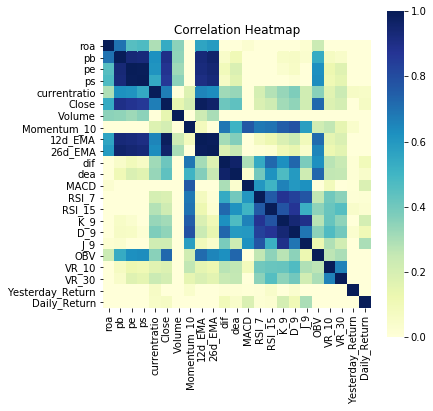

In [369]:
fig, ax = plt.subplots(figsize = (6,6))
sns.heatmap(df.corr(),vmin = 0, xticklabels= True, yticklabels= True, square=True,  cmap="YlGnBu")
ax.set_title("Correlation Heatmap")

Text(0.5, 1.0, 'AAPL Stock Price')

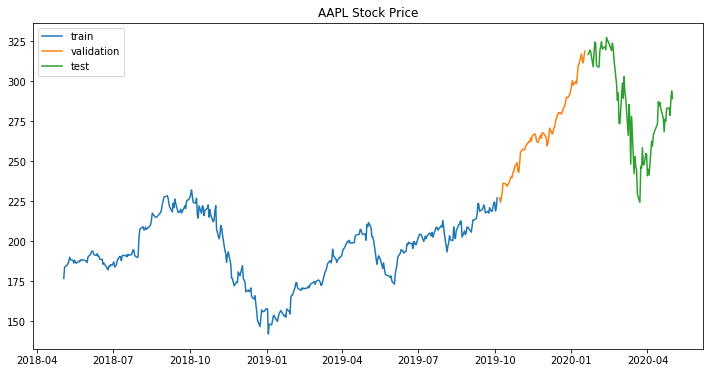

In [348]:
plt.figure(figsize=(12,6))
plt.plot(df['Close'].iloc[0:int(len(df)/7*5)])
plt.plot(df['Close'].iloc[int(len(df)/7*5):int(len(df)/7*6)])
plt.plot(df['Close'].iloc[int(len(df)/7*6):])
plt.legend(['train', 'validation', 'test'])
plt.title('AAPL Stock Price')

In [316]:
scaler_X = StandardScaler()
scaler_X.fit(df.iloc[0:int(len(df)/7*6),1:int(len(df)/7*6/20)])
scaled_X = scaler_X.transform(df.iloc[:, 1:int(len(df)/7*6/20)])
scaler_Y = StandardScaler()
scaler_Y.fit(np.array(df.iloc[0:int(len(df)/7*6),-1]).reshape(-1,1))
scaled_Y = scaler_Y.transform(np.array(df.iloc[:,-1]).reshape(-1,1))

Text(0.5, 1.0, 'All the Features and Returns')

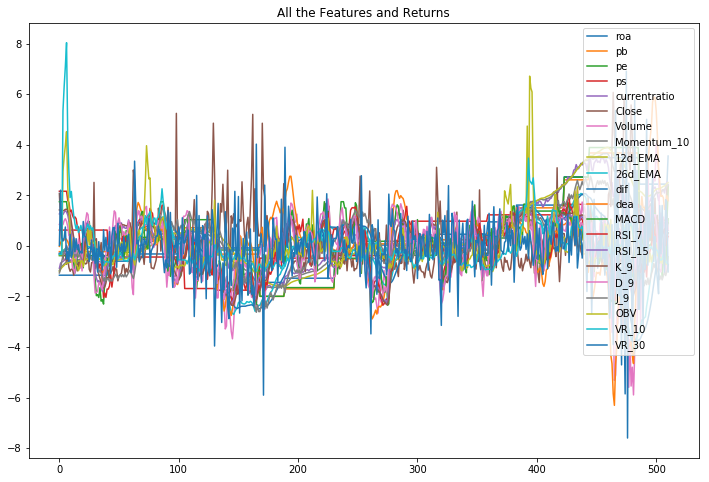

In [317]:
plt.figure(figsize=(12,8))
plt.plot(scaled_X)
plt.plot(scaled_Y)
plt.legend(df.columns)
plt.title("All the Features and Returns")

Then we need to split the data into 3 groups, 5:5:1, train, validation and test dataset.

In [318]:
train_X = scaled_X[0:int(len(df)/7*5),:]
train_Y = scaled_Y[0:int(len(df)/7*5)]
val_X = scaled_X[int(len(df)/7*5):int(len(df)/7*6), :]
val_Y = scaled_Y[int(len(df)/7*5):int(len(df)/7*6)]
test_X = scaled_X[int(len(df)/7*6):,:]
test_Y = df.iloc[int(len(df)/7*6):, -1]

## 3. Model Implementation

### 3.1 Set Model

In [319]:
models = {
          'SVM_rbf':svm.SVR(gamma='auto'), # SVM
          'SVM_poly':svm.SVR(kernel = 'poly', gamma='auto'),
          'SGD':SGDRegressor(max_iter=1000, tol=0.0005), # Stochastic Gredient Descent
          'Random_Forest':RFR()} # Random Forest

### 3.2 Train the Model

In [320]:
min_MSE = 100000
for model_name, model in models.items():
    regressor = model.fit(train_X,np.ravel(train_Y))
    predicted_val = regressor.predict(val_X) # predict on the validation dataset
    error = MSE(np.ravel(predicted_val),val_Y)
    print(model_name+": %.6f" % error)
    if error<min_MSE:
        min_MSE = error
        best_model = model_name
        best_regressor = regressor
    l
print("Best Model: "+best_model)

SVM_rbf: 0.322423
SVM_poly: 1.346406
SGD: 0.332687
Random_Forest: 0.271519
Best Model: Random_Forest


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## 4. Model Testing and Evaluation

### 4.1 Prediction on Test Dataset

In [321]:
scaled_predicted_Y = best_regressor.predict(test_X)
predicted_Y = scaler_Y.inverse_transform(scaled_predicted_Y)
test_MSE = MSE(predicted_Y,test_Y)

In [322]:
test_MSE

0.0012855454101981022

### 4.2 Data Visualization

According to the above analyzation, calculation and estimation, we find that in this case, Random Forest Model performs the best. Set the original stock price at time 0 as 1, then we can plot the stock price as follows

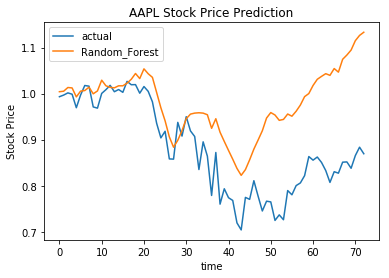

In [323]:
cumulative_actual = np.cumprod(test_Y + 1)
cumulative_predicted = np.cumprod(predicted_Y + 1)
plt.plot(np.arange(0,len(test_Y)), cumulative_actual)
plt.plot(np.arange(0,len(test_Y)),cumulative_predicted)
plt.title('AAPL Stock Price Prediction')
plt.xlabel('time')
plt.ylabel('Stock Price')
plt.legend(["actual",best_model])
plt.show()

From above, we notice that Random Forest Model performs great in this case, it captures the main changes in stock price. We will repeat the above steps for all the stocks in Dow Jones.

### 4.3 Implementation on All Stocks

DOW
Best Model: SVM_poly
Min MSE is 0.0025403263535022677


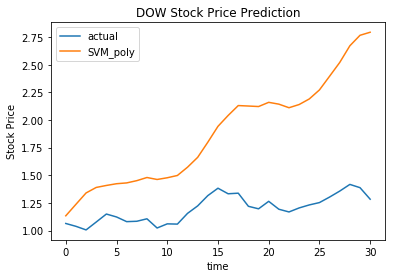

UNH
Best Model: SGD
Min MSE is 0.0013143024607208363


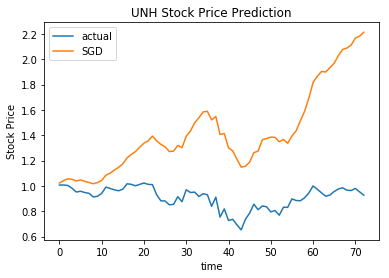

CAT
Best Model: SGD
Min MSE is 0.0007982958034126908


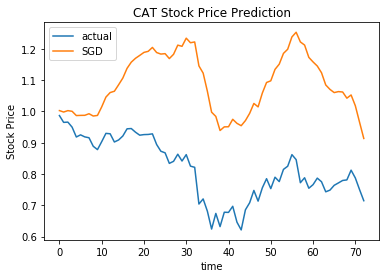

BA
Best Model: SGD
Min MSE is 0.0039096756292357655


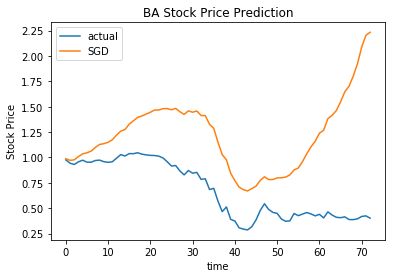

XOM
Best Model: SGD
Min MSE is 0.0017247729985258333


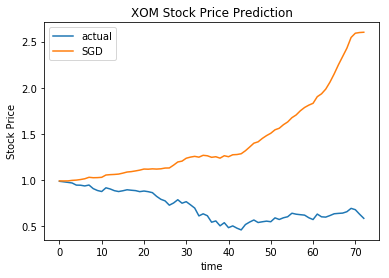

WBA
Best Model: SGD
Min MSE is 0.0011742197428199097


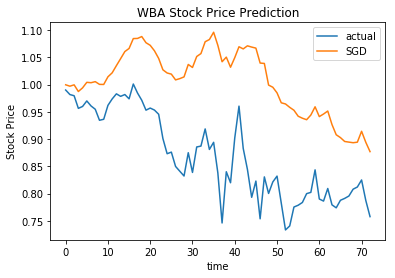

MMM
Best Model: SGD
Min MSE is 0.0007262315440505807


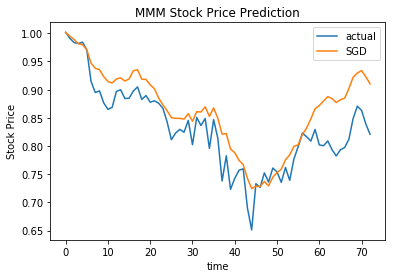

WMT
Best Model: SVM_rbf
Min MSE is 0.0008306203193623574


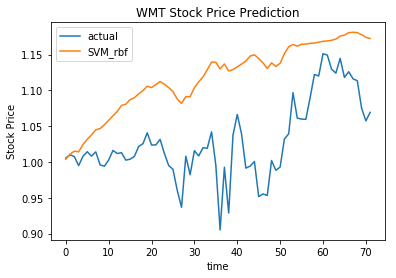

DIS
Best Model: SGD
Min MSE is 0.0011594520625343614


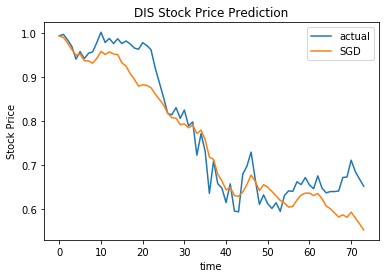

JNJ
Best Model: SGD
Min MSE is 0.0004912369117799076


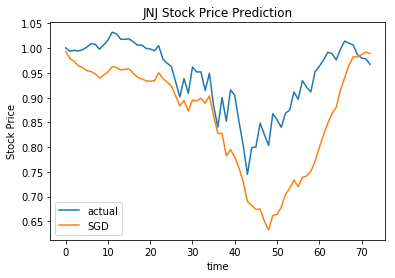

CSCO
Best Model: SVM_rbf
Min MSE is 0.0013908569591495573


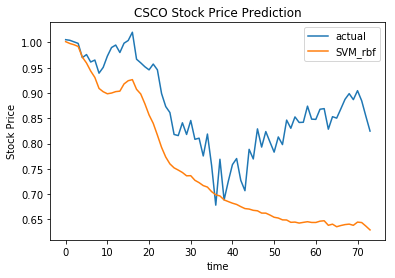

HD
Best Model: SGD
Min MSE is 0.001267861493004799


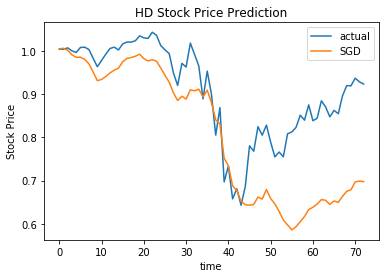

CVX
Best Model: SGD
Min MSE is 0.002059046367214611


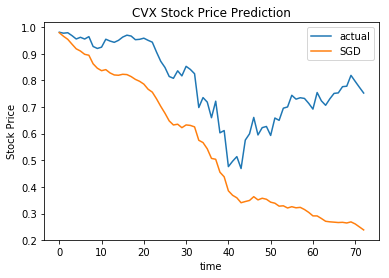

IBM
Best Model: SGD
Min MSE is 0.0007877543674551179


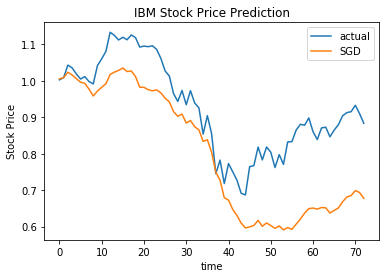

MSFT
Best Model: SVM_rbf
Min MSE is 0.0018312090918767994


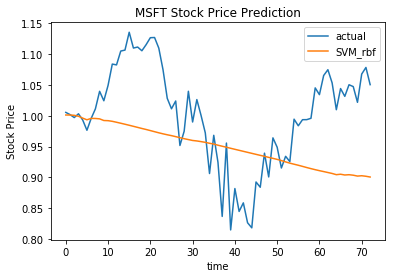

MRK
Best Model: SGD
Min MSE is 0.0005216105287110476


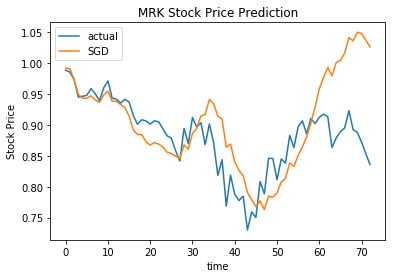

NKE
Best Model: SVM_rbf
Min MSE is 0.0014583830100284973


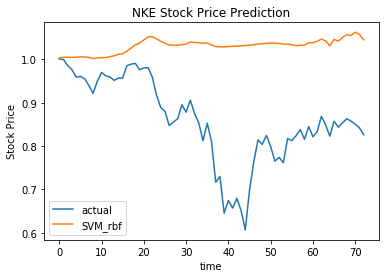

V
Best Model: SGD
Min MSE is 0.0012951156238971365


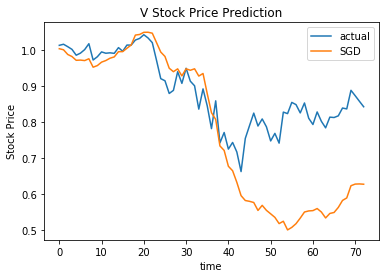

PG
Best Model: SGD
Min MSE is 0.0009127767662229033


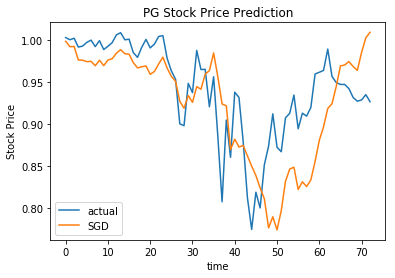

VZ
Best Model: SGD
Min MSE is 0.0002824087519301169


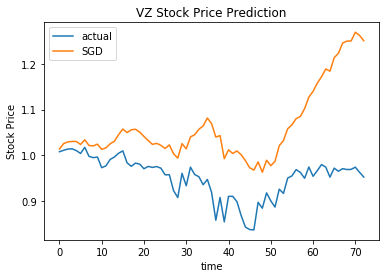

KO
Best Model: SGD
Min MSE is 0.0008793003056120035


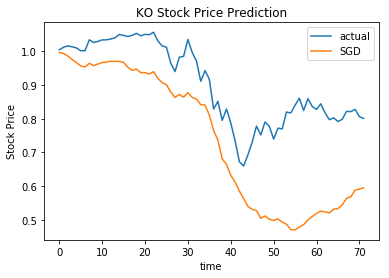

INTC
Best Model: SGD
Min MSE is 0.0025885648547671856


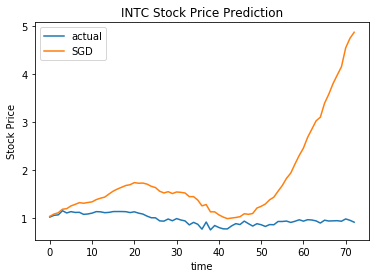

PFE
Best Model: SGD
Min MSE is 0.0005502133102358236


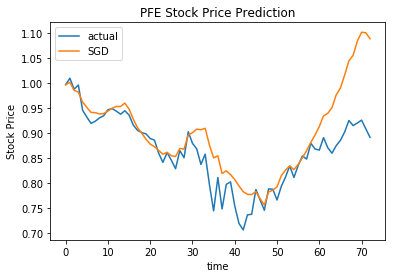

MCD
Best Model: SGD
Min MSE is 0.0012236637637445698


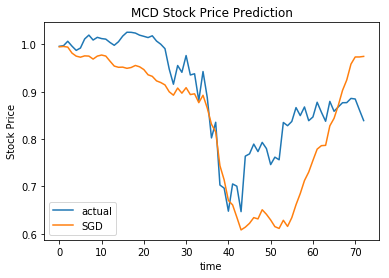

AAPL
Best Model: Random_Forest
Min MSE is 0.0012709272347377917


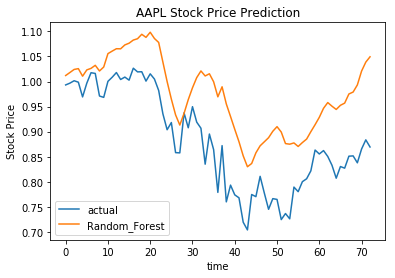

In [327]:
for ticker in stock_list:
    df = pd.read_csv('Data/'+ticker+'.csv')
    df = df.replace(np.inf,1)
    df.index = pd.to_datetime(df[df.columns[0]])
    df = df.drop(df.columns[0],axis=1)
    # Some stocks lack much data, just remove them.
    if len(df)>100:
        print(ticker)
        scaler_X = StandardScaler()
        scaler_X.fit(df.iloc[0:int(len(df)/7*6),1:int(len(df)/7*6/20)])
        scaled_X = scaler_X.transform(df.iloc[:, 1:int(len(df)/7*6/20)])
        scaler_Y = StandardScaler()
        scaler_Y.fit(np.array(df.iloc[0:int(len(df)/7*6),-1]).reshape(-1,1))
        scaled_Y = scaler_Y.transform(np.array(df.iloc[:,-1]).reshape(-1,1))
        train_X = scaled_X[0:int(len(df)/7*5),:]
        train_Y = scaled_Y[0:int(len(df)/7*5)]
        val_X = scaled_X[int(len(df)/7*5):int(len(df)/7*6), :]
        val_Y = scaled_Y[int(len(df)/7*5):int(len(df)/7*6)]
        test_X = scaled_X[int(len(df)/7*6):,:]
        test_Y = df.iloc[int(len(df)/7*6):, -1]
        min_MSE = 10

        for model_name, model in models.items():
            regressor = model.fit(train_X,np.ravel(train_Y))
            predicted_val = regressor.predict(val_X)
            error = MSE(np.ravel(predicted_val),val_Y)
            if error<min_MSE:
                min_MSE = error
                best_model = model_name
                best_regressor = regressor
        scaled_predicted_Y = best_regressor.predict(test_X)
        predicted_Y = scaler_Y.inverse_transform(scaled_predicted_Y)
        test_MSE = MSE(predicted_Y,test_Y)
        print('Best Model: '+best_model)
        print('Min MSE is '+str(test_MSE))
        cumulative_actual = np.cumprod(test_Y+1)
        cumulative_predicted = np.cumprod(predicted_Y+1)
        plt.plot(np.arange(0,len(test_Y)), cumulative_actual, label='actual')
        plt.plot(np.arange(0,len(test_Y)),cumulative_predicted,label='prediction')
        plt.title( ticker + ' Stock Price Prediction')
        plt.xlabel('time')
        plt.ylabel('Stock Price')
        plt.legend(["actual",best_model])
        plt.show()

## 5. Conclusions

According to the above graphs, we find that in most cases, our model performs well and has a quite small MSE, which means that our model can capture the main changes and trends in the stock.<br />

This method gives us some suggestions on how to select stocks. We can do the regression on a regular basis such as once every ten days, update our predictions on stock returns and select stocks with higher potential returns.<br />

Besides, there are still some aspects that we can consider, We can use NLP or try dimension reduction techniques to improve the algorithm. As for the factors, we can do more researches to mine more effective factors to make a better prediction. <br />

Finally, financial market is changing rapidly everyday, factor may not be effective for a long time, since every quant will start use it and it will be ineffective eventually. Thus, we need to adjust our factors and models dynamically and regularly to maintain the whole system.
